 # Airbnb case

## 0. Data Load and Prepare

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling


In [2]:
df=pd.read_csv('../data/listings.csv', index_col='id')
df.head()


,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,,,
9784567,nice Room in Amsterdam,27280608,Petra,NaN,Bijlmer-Oost,52.323369,4.977730,Private room,95,1,5,2016-06-27,0.81,3,365
13163805,Best cost benefit room near a metro station,35491461,Phillip,NaN,Bijlmer-Oost,52.315635,4.978166,Private room,60,1,4,2016-06-27,4.00,1,77
3719167,Nice room in A´dam SE near nature & heart centre,18991270,Maria,NaN,Bijlmer-Oost,52.316711,4.986618,Private room,45,5,11,2016-01-02,0.48,1,23
13188367,Private room 15min metro ride from city center,73797940,Diana,NaN,Bijlmer-Oost,52.321204,4.976630,Private room,35,1,2,2016-05-31,1.62,1,10
4831606,Room in Amsterdam in a new house!! Free Bicycle,24314617,Jorim,NaN,Bijlmer-Oost,52.327270,4.967352,Private room,39,14,12,2016-03-22,0.65,1,338


In [3]:
df['last_review']=pd.to_datetime(df['last_review'], yearfirst=True)
df.drop(axis=1, columns=['name','host_id','host_name','neighbourhood_group'], inplace=True)
df.dtypes

neighbourhood                             object
latitude                                 float64
longitude                                float64
room_type                                 object
price                                      int64
minimum_nights                             int64
number_of_reviews                          int64
last_review                       datetime64[ns]
reviews_per_month                        float64
calculated_host_listings_count             int64
availability_365                           int64
dtype: object

In [4]:
shape = df.shape
cols = df.columns
print(shape, '\n', cols)

(13849, 11) 
 Index(['neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')


## 3. Find ROI

first we'll get rough estimate of *gain of investment* as average price per night a house is rented out times 365 - gain for the whole year. <br>
First, let's check how skewed price is - so to decide whether mean or median price would be a better measure. It seems we have a number of exceptionally highly priced properties, median seems to be a better measure of how much we'll be able to charge.

In [5]:
df['price'].describe()

count    13849.000000
mean       132.837100
std        105.267487
min         10.000000
25%         89.000000
50%        115.000000
75%        150.000000
max       8616.000000
Name: price, dtype: float64

In [14]:
df_roi = pd.DataFrame({'measure':['mean_price', 'median_price', 'gain_yr_med'],
                       'overall': [df['price'].describe()[1], df['price'].describe()[5], df['price'].describe()[5]*365],
                      'house': [df[df['room_type']=='Entire home/apt']['price'].describe()[1], df[df['room_type']=='Entire home/apt']['price'].describe()[5], df[df['room_type']=='Entire home/apt']['price'].describe()[5]*365],
                      'room': [df[df['room_type']=='Private room']['price'].describe()[1], df[df['room_type']=='Private room']['price'].describe()[5],df[df['room_type']=='Private room']['price'].describe()[5]*365],
                      'shared_room': [df[df['room_type']=='Shared room']['price'].describe()[1], df[df['room_type']=='Shared room']['price'].describe()[5], df[df['room_type']=='Shared room']['price'].describe()[5]*365],
                      })
df_roi

,measure,overall,house,room,shared_room
0,mean_price,132.8371,145.809652,79.106938,66.521127
1,median_price,115.0000,125.000000,73.000000,46.000000
2,gain_yr_med,41975.0000,45625.000000,26645.000000,16790.000000


Ok, from the table above it is clear it's more profitable to rent out entire house, although it would be illegal to do for the whole year. Second best choice here is private room via registered B&B (of course the taxes will add to the costs then). <br>
Lets' then calculate ROI for 3 things: 
- entire house (against gemeente rules)
- private room (via B&B)
- no distinction (based on overall median)

## 2. Gemeente Rules Violations and illegal gain

Looking at the data, there are 2 major violations of the existing rules:
- Entire house is rented out for more than 60 days in a year [Particuliere vakantieverhuur]
- One host rents out more than 1 object [Particuliere vakantieverhuur] in both house and rooms categories

Let's calculate the illegal gain in the following categories:
- gain renting out for more than 60 days (only entire house, not accounting for multiplicity)
- gain for multiplicity (as total gain from all multiple objects)
- overall gain, that is multiple objects + the rest exceeding 60 days (not a sum of 1 and 2!)

In addition let's add calculated violations gain as % of the entire market gain

In [55]:
cond1=(df.availability_365 > 60) & (df.room_type=='Entire home/apt') #renting out house for more than 60 days
cond2=df.calculated_host_listings_count>1 #multiple objects per host
cond3=cond1 & -cond2 #violation 1, but not 2 (only 1 object per host)

#total gain violating 1st condition (60 days)
gain_1 = sum(df[cond1]['price']*df[cond1]['availability_365']-df[cond1]['price']*60)
#total gain violating  2nd condition (1 object)
gain_2 = sum(df[cond2]['price']*df[cond2]['availability_365'])
#total gain violating 1 object per host condition + total gain violating 60 days (where IS only 1 object per host)
gain_tot = sum(df[cond3]['price']*df[cond3]['availability_365']-df[cond3]['price']*60) + gain_2

#Now, the entrie market gain:
market_gain = sum(df['price']*df['availability_365'])

#put all to dataframe:
df_vio = pd.DataFrame({'Type violation':['>60 days', '>1 object', 'Both'],
                      'Gain': [gain_1, gain_2, gain_tot],
                       '% of entire market': [gain_1/market_gain*100,gain_2/market_gain*100,gain_tot/market_gain*100]
                      })
df_vio

,Type violation,Gain,% of entire market
0,>60 days,154855834,61.171120
1,>1 object,76615874,30.264787
2,Both,189184478,74.731614


## 1. Give advices

In [5]:
df['months_exist']=df['number_of_reviews']/df['reviews_per_month']
df.head(20)

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,months_exist
id,,,,,,,,,,,,
9784567,Bijlmer-Oost,52.323369,4.977730,Private room,95,1,5,2016-06-27,0.81,3,365,6.172840
13163805,Bijlmer-Oost,52.315635,4.978166,Private room,60,1,4,2016-06-27,4.00,1,77,1.000000
3719167,Bijlmer-Oost,52.316711,4.986618,Private room,45,5,11,2016-01-02,0.48,1,23,22.916667
13188367,Bijlmer-Oost,52.321204,4.976630,Private room,35,1,2,2016-05-31,1.62,1,10,1.234568
4831606,Bijlmer-Oost,52.327270,4.967352,Private room,39,14,12,2016-03-22,0.65,1,338,18.461538
13727930,Bijlmer-Oost,52.314587,4.975385,Entire home/apt,80,2,0,NaT,NaN,1,9,NaN
591951,Bijlmer-Oost,52.326981,4.982949,Entire home/apt,191,2,24,2016-06-26,0.51,1,346,47.058824
9833390,Bijlmer-Oost,52.314588,4.982022,Entire home/apt,129,2,1,2016-05-06,0.50,1,41,2.000000
13601947,Bijlmer-Oost,52.318814,4.980409,Entire home/apt,120,2,1,2016-06-27,1.00,1,39,1.000000


/home/ant_on_su/miniconda3/envs/case/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ant_on_su/miniconda3/envs/case/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([5.045e+03, 2.950e+03, 1.624e+03, 7.770e+02, 5.160e+02, 3.090e+02,
        1.000e+02, 5.700e+01, 7.000e+00, 1.000e+00]),
 array([ 1.        ,  9.75245902, 18.50491803, 27.25737705, 36.00983607,
        44.76229508, 53.5147541 , 62.26721311, 71.01967213, 79.77213115,
        88.52459016]),
 <a list of 10 Patch objects>)

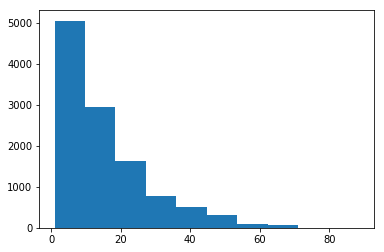

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.hist(df['months_exist'])

In [11]:
df['months_exist'].describe()

count    11386.000000
mean        14.801646
std         13.330265
min          1.000000
25%          4.296128
50%         11.111111
75%         22.077922
max         88.524590
Name: months_exist, dtype: float64

/home/ant_on_su/miniconda3/envs/case/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  


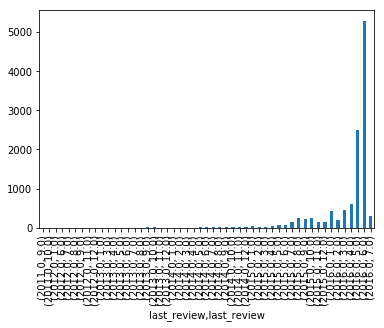

In [35]:

df['last_review'].groupby(by=(df.last_review.dt.year, df.last_review.dt.month)).count().plot(kind='bar')

/home/ant_on_su/miniconda3/envs/case/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/ant_on_su/miniconda3/envs/case/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


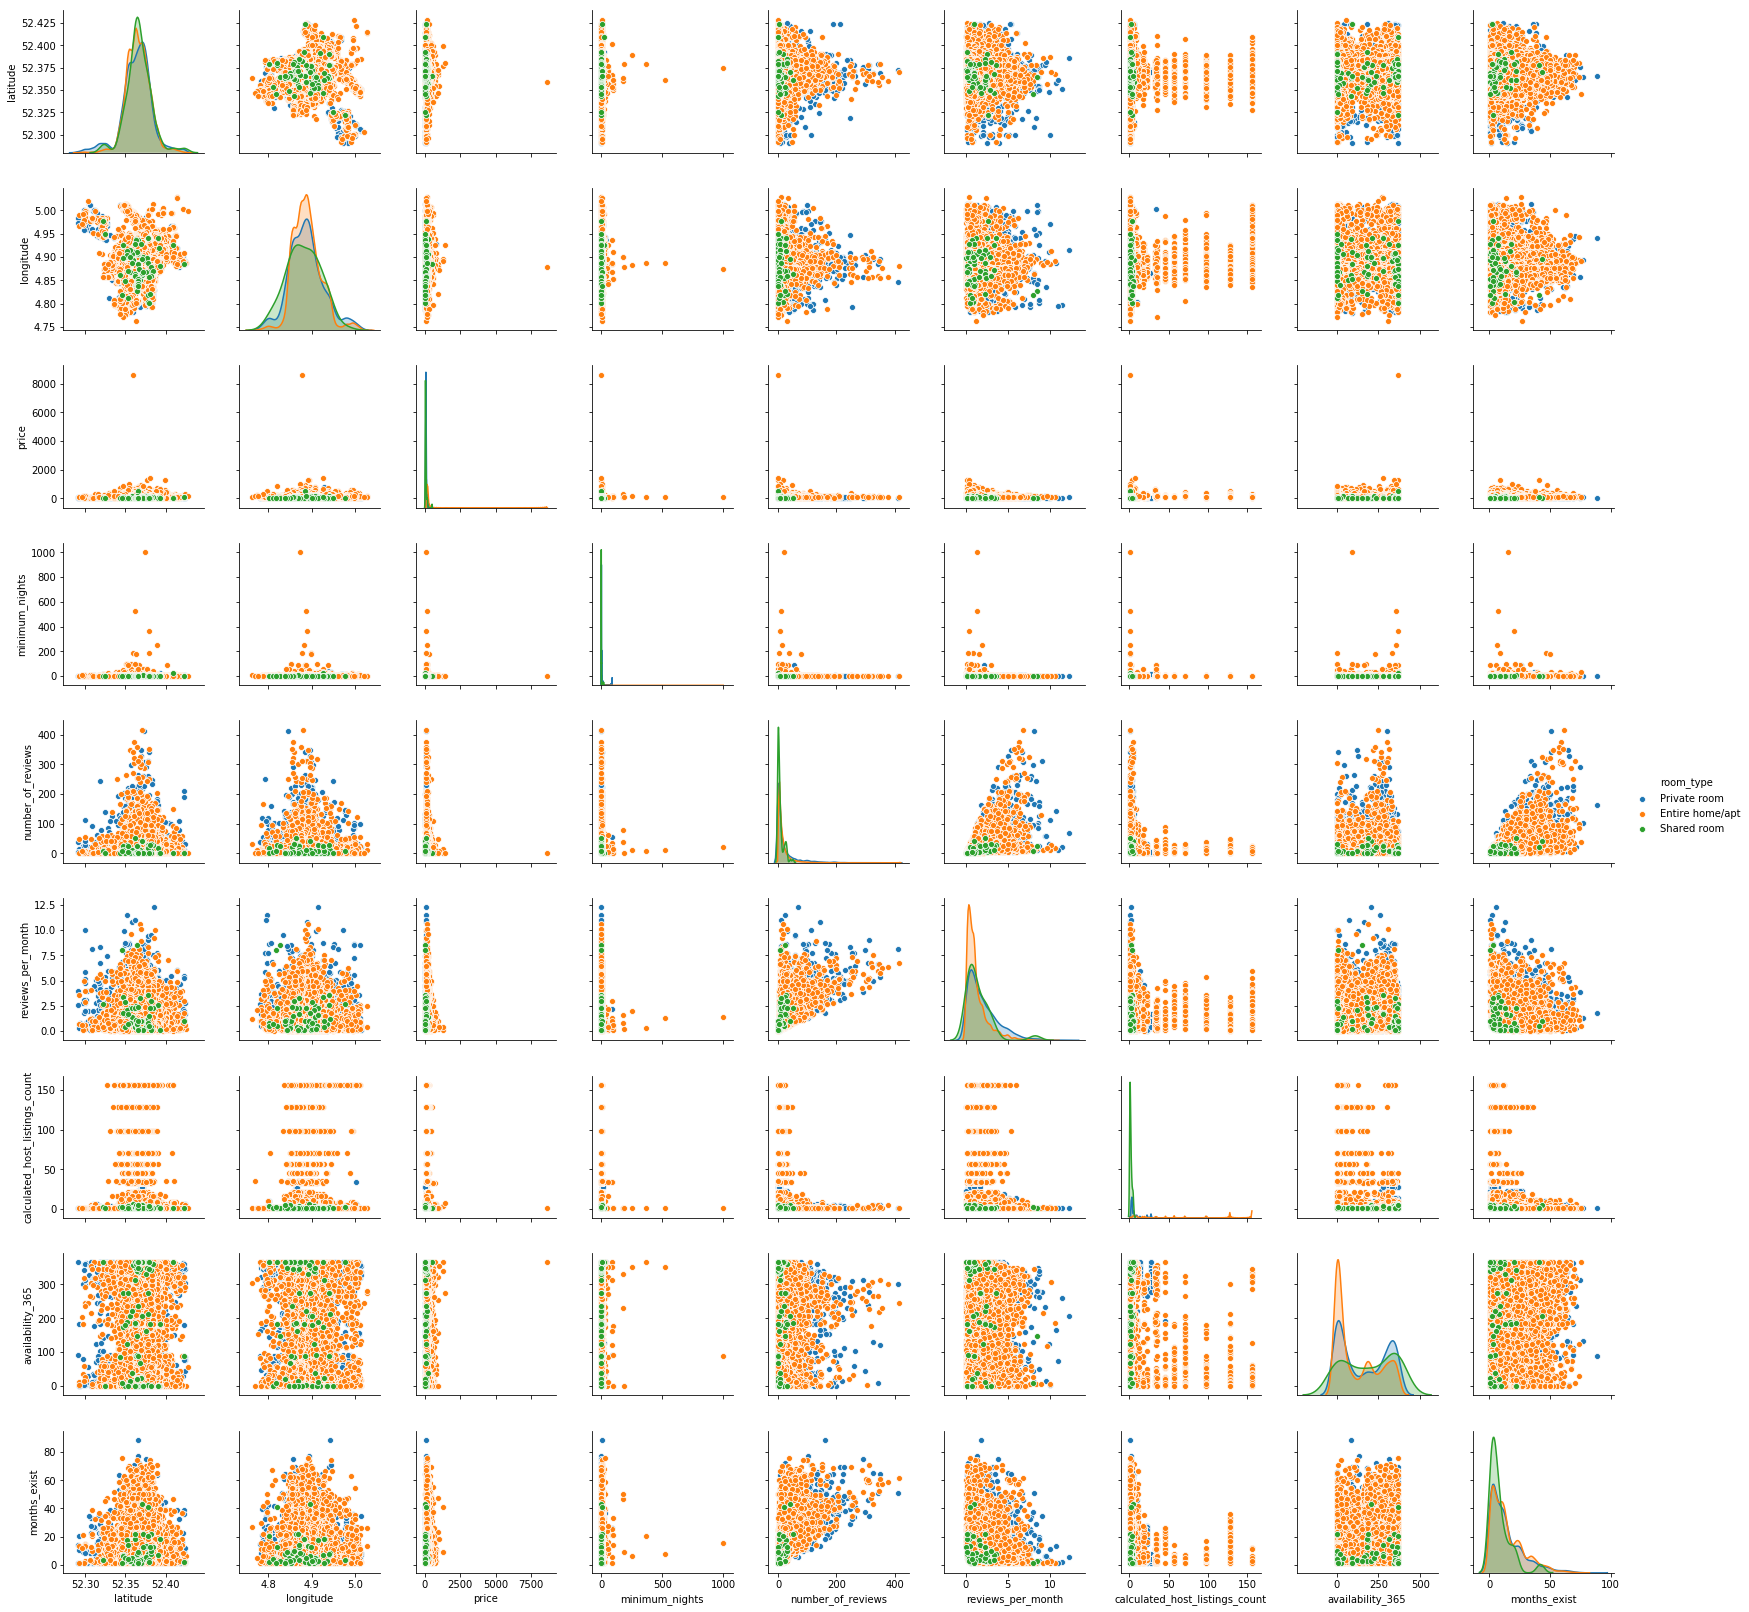

In [13]:
%matplotlib inline
import seaborn as sns

sns.pairplot(df, hue='room_type')


[(0, 400)]

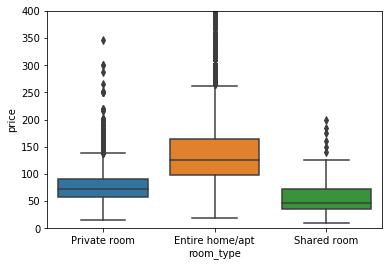

In [28]:
box=sns.boxplot(data=df, x='room_type', y='price')
box.set(ylim=(0, 400))

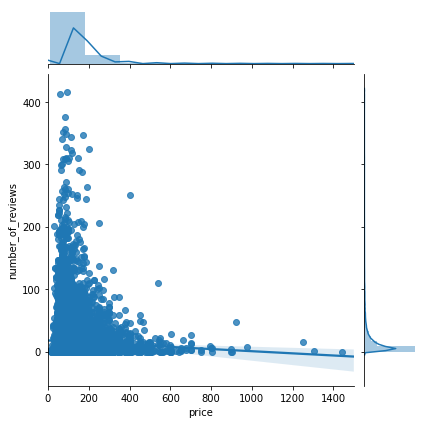

In [22]:
sns.jointplot(df.price, df.number_of_reviews, kind='reg', xlim=(0,1500))

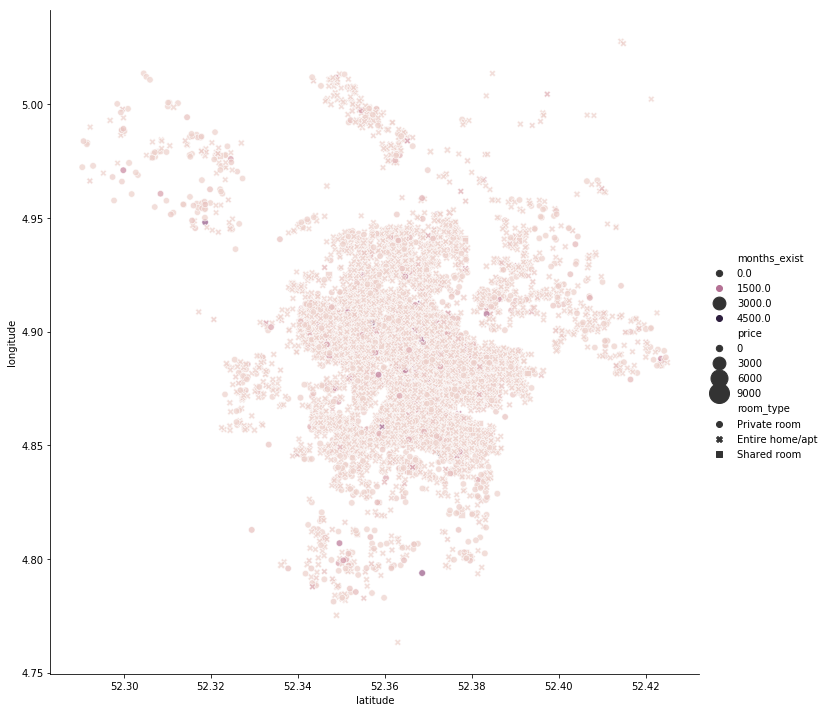

In [7]:
sns.relplot(x='latitude', y='longitude', style='room_type', size='price', hue='months_exist', alpha=0.7, data=df, sizes=(40, 400), height=10)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


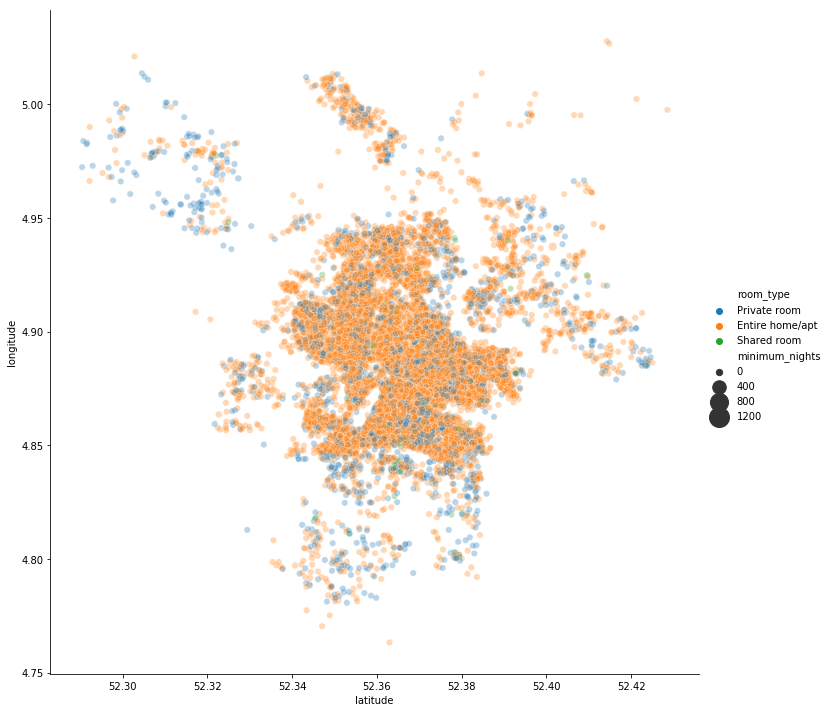

In [14]:
%time
sns.relplot(x='latitude', y='longitude', hue='room_type', size='minimum_nights', alpha=0.3, data=df, sizes=(40, 400), height=10)

## Clustering: let's try

### Affinity Propagation:

In [6]:
X=df.drop(axis=1, columns=['neighbourhood','months_exist','last_review'])
X.columns

Index(['latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

In [7]:
X['room_type']=X['room_type'].map({'Entire home/apt' :0, 'Private room':1, 'Shared room' :2})

In [8]:
X['reviews_per_month'].fillna(value=0, inplace=True)
X.head()

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,
9784567,52.323369,4.977730,1,95,1,5,0.81,3,365
13163805,52.315635,4.978166,1,60,1,4,4.00,1,77
3719167,52.316711,4.986618,1,45,5,11,0.48,1,23
13188367,52.321204,4.976630,1,35,1,2,1.62,1,10
4831606,52.327270,4.967352,1,39,14,12,0.65,1,338


In [ ]:
%%time
from sklearn.cluster import AffinityPropagation
import numpy as np
cluster=AffinityPropagation()
cluster.fit(X)

### KMeans

In [9]:
from scipy import stats
X=stats.zscore(X)

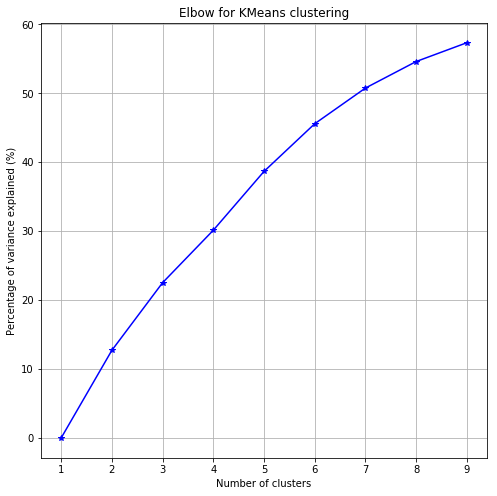

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import distance
Ks = range(1, 10)
kmean = [KMeans(n_clusters=i).fit(X) for i in Ks]

def plot_elbow(kmean, X):
    centroids = [k.cluster_centers_ for k in kmean]
    D_k = [distance.cdist(X, center, 'euclidean') for center in centroids]
    dist = [np.min(D,axis=1) for D in D_k]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(distance.pdist(X)**2)/X.shape[0]
    bss = tss-wcss

    plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax = plt.subplot(1, 1, 1)
    ax.plot(Ks, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained (%)')
    plt.title('Elbow for KMeans clustering')
    plt.show()

plot_elbow(kmean, X)
